# Valutazione e Ricalcolo della Matrice di Intensità Emotiva
In ItEm, i centroidi venivano costruiti partendo da parole "seme" (seed). In ELIta, poiché abbiamo già tutto il lessico annotato, definiremo come "semi" le parole che hanno un punteggio molto alto in una determinata emozione e basso nelle altre (usando la formula della distintività). 

Implementeremo la formula di ItEm per calcolare la distintività di ogni parola per ogni emozione, selezioneremo le parole più distintive come semi, e ricalcoleremo la matrice di intensità emotiva basandoci su questi semi.

Questa formula serve a capire quanto una parola è "pura" per un'emozione. Se una parola ha un *d* alto per la "Gioia", significa che non è ambigua.

Creeremo nuovi punteggi combinando:
   1. Il punteggio originale di ELIta (*e*)
   2. La similarità coseno tra il vettore della parola e il centroide dell'emozione (*cos*)

La formula finale sarà: `e = 𝛼cos + (1 - 𝛼)e`, con più valori di 𝛼 da testare (0.2, 0.5, 0.8).

## Import e caricamento dati

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from Fase1.emotion_config import BASIC_EMOTIONS, EMOTION_COLORS

df_matrix = pd.read_csv("../Fase1/ELIta_INTENSITY_Matrix.csv", index_col=0)
df_emotions = df_matrix[BASIC_EMOTIONS].fillna(0) # Carichiamo il dataset di ELIta con le emozioni di base

print(f"Dataset caricato: {df_emotions.shape[0]} parole e {df_emotions.shape[1]} emozioni.")

Dataset caricato: 6905 parole e 8 emozioni.


## Calcolo della Distintività
Calcoliamo la distintività di ogni parola per ogni emozione usando la formula di ItEm.

In [2]:
def calculate_distinctiveness(row):
    # Ordina i valori della riga per trovare max1 e max2
    sorted_values = sorted(row.values, reverse=True)
    max1 = sorted_values[0]
    max2 = sorted_values[1]
    mn = np.mean(row.values)
    
    d_scores = {}
    for emo in BASIC_EMOTIONS:
        me = row[emo]
        if me == 0:
            d_scores[emo] = 0
        else:
            d = ((max1 - max2) / (me + 1e-9)) * (max1 - mn) # Formula ItEm
            d_scores[emo] = max(0, d)
    return pd.Series(d_scores)

df_distinctiveness = df_emotions.apply(calculate_distinctiveness, axis=1)

## Selezione delle parole semi
Calcoliamo i centroidi delle emozioni usando le parole più distintive come semi.

In [3]:
centroids = {}
for emo in BASIC_EMOTIONS:
    top_seeds = df_distinctiveness[emo].sort_values(ascending=False).head(50).index # Prendiamo le prime 50 parole più distintive per ogni emozione
    centroids[emo] = df_emotions.loc[top_seeds].mean().values # Calcoliamo il centroide come media dei vettori delle parole semi

df_centroids = pd.DataFrame(centroids, index=BASIC_EMOTIONS).T

## Calcolo della Similarità Coseno
Calcoliamo la similarità coseno tra ogni parola e ogni centroide

In [4]:
cos_sim_matrix = cosine_similarity(df_emotions.values, df_centroids.values)
df_cos_sim = pd.DataFrame(cos_sim_matrix, index=df_emotions.index, columns=BASIC_EMOTIONS)

## Ricalcolo della Matrice di Intensità Emotiva
Applichiamo la formula `e = 𝛼cos + (1 - 𝛼)e` per diversi valori di 𝛼

In [5]:
def recalculate_scores(df_orig, df_cos, alpha):
    return (alpha * df_cos) + ((1 - alpha) * df_orig)

df_alpha_02 = recalculate_scores(df_emotions, df_cos_sim, 0.2)
df_alpha_05 = recalculate_scores(df_emotions, df_cos_sim, 0.5)
df_alpha_08 = recalculate_scores(df_emotions, df_cos_sim, 0.8)

parola_test = "amore" 
confronto = pd.DataFrame({
    'Originale': df_emotions.loc[parola_test],
    'Coseno (Distrib)': df_cos_sim.loc[parola_test],
    'Alpha 0.5 (Nuovo)': df_alpha_05.loc[parola_test]
})
print(f"Confronto per la parola '{parola_test}':")
print(confronto)

Confronto per la parola 'amore':
             Originale  Coseno (Distrib)  Alpha 0.5 (Nuovo)
gioia             1.00          0.691441           0.845720
tristezza         0.67          0.918238           0.794119
rabbia            0.42          0.939176           0.679588
paura             0.46          0.919558           0.689779
disgusto          0.04          0.939771           0.489886
fiducia           0.83          0.749804           0.789902
sorpresa          0.54          0.666924           0.603462
aspettativa       0.96          0.520637           0.740319


---
# Analisi del cambiamento
Visualizziamo come i punteggi emotivi di alcune parole cambiano con il ricalcolo.

In [6]:
df_delta = (df_alpha_05 - df_emotions).abs() # Cambiamento assoluto tra originale e ricalcolato con alpha 0.5

print("Cambiamento medio dei punteggi per emozione (Alpha 0.5):")
print(df_delta.mean())

import plotly.express as px
fig_delta = px.box(df_delta, title="Distribuzione del cambiamento dei punteggi (Originale vs Ibrido 0.5)")
fig_delta.show()

Cambiamento medio dei punteggi per emozione (Alpha 0.5):
gioia          0.242377
tristezza      0.291486
rabbia         0.294509
paura          0.276240
disgusto       0.308029
fiducia        0.233517
sorpresa       0.209653
aspettativa    0.200269
dtype: float64


#TODO: spiegare meglio cosa si vede in questi grafici

## Visualizzazione dei risultati
Visualizziamo i punteggi emotivi originali e ricalcolati per alcune parole chiave.

In [7]:
from Fase1.pca_utils import perform_pca_analysis
from Fase1.visualizer import plot_pca_single
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 1. PCA su dati Originali
dom_orig = df_emotions.idxmax(axis=1)
pca_orig = perform_pca_analysis(df_emotions, BASIC_EMOTIONS, dom_orig, scale=True)

# 2. PCA su dati Alpha 0.5 (Ibrido bilanciato)
dom_05 = df_alpha_05.idxmax(axis=1)
pca_05 = perform_pca_analysis(df_alpha_05, BASIC_EMOTIONS, dom_05, scale=True)

# 3. PCA su dati Alpha 0.8 (Dominanza distribuzionale)
dom_08 = df_alpha_08.idxmax(axis=1)
pca_08 = perform_pca_analysis(df_alpha_08, BASIC_EMOTIONS, dom_08, scale=True)

def compare_pca_layouts(pca_list, titles):
    fig = make_subplots(rows=1, cols=len(pca_list), subplot_titles=titles, horizontal_spacing=0.05)
    
    for i, pca_data in enumerate(pca_list):
        df = pca_data['df']
        for emo in BASIC_EMOTIONS:
            emo_data = df[df['Emozione Dominante'] == emo]
            fig.add_trace(
                go.Scatter(
                    x=emo_data['PC1'], y=emo_data['PC2'],
                    mode='markers',
                    marker=dict(color=EMOTION_COLORS[emo], size=5, opacity=0.6),
                    name=emo,
                    showlegend=(i == 0), # Mostra legenda solo per il primo grafico
                    legendgroup=emo
                ),
                row=1, col=i+1
            )
    
    fig.update_layout(title_text="Confronto della compattezza degli spazi emotivi (Originale -> Ibrido)")
    fig.show()

compare_pca_layouts([pca_orig, pca_05, pca_08], ["Originale (Alpha 0)", "Ibrido (Alpha 0.5)", "Ibrido (Alpha 0.8)"])

---
# Mappa semantica  e Scatter Plot
#TODO: fare meglio mappa semantica e scatter plot
## Mappa semantica con NetworkX
Questo grafico usa la libreria NetworkX. Non è un semplice grafico a dispersione: mostra dei collegamenti (archi) tra le parole.

- Nodi: sono le parole.
- Archi (linee): disegnati solo se la similarità coseno tra due parole è molto alta (noi useremo 0.9).
- Posizionamento: coordinate dei nodi calcolate tramite t-SNE.

## Scatter Plot
Questo grafico usa Seaborn. È una proiezione pura degli embedding BERT in 2D. Serve a vedere la "distanza" geometrica tra i concetti senza le linee di connessione.

- Asse X e Y: Dimensioni astratte generate dall'algoritmo t-SNE.
- Etichette: Ogni punto ha il nome della parola accanto.

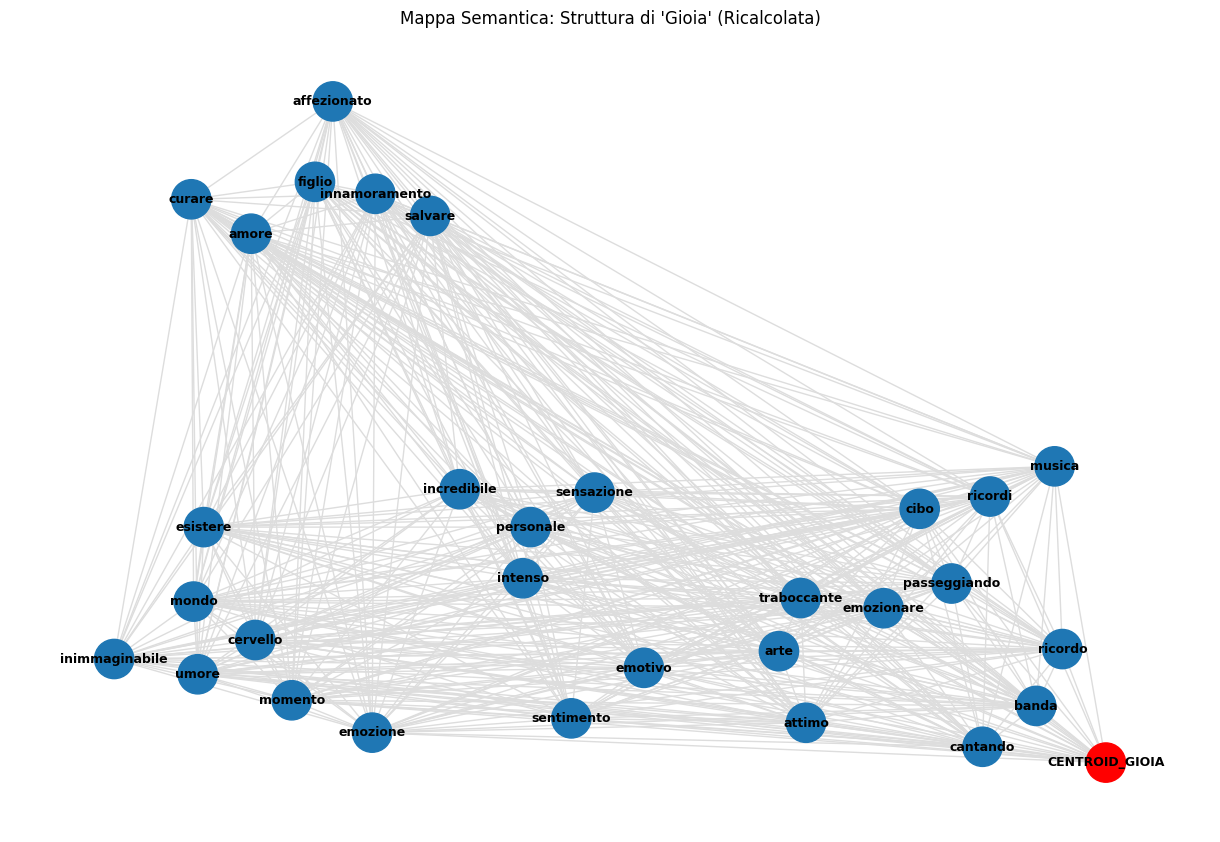

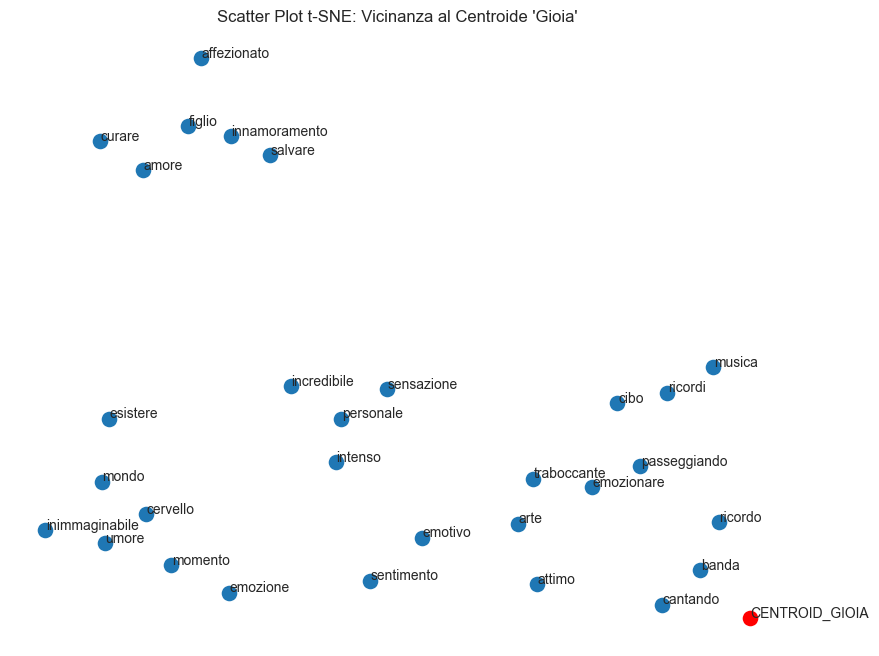

In [8]:
from Fase2.support import plot_semantic_structure

plot_semantic_structure(df_alpha_05, df_centroids, 'gioia')